In [21]:
import numpy as np
import pandas as pd

if 'google.colab' in str(get_ipython()):
    !pip install astroquery

Get list of TOIs that are 1) confirmed , and 2) giant planets

In [69]:
from astropy.utils.data import download_file

# Basically getting  the list of TOIs from 
# - it can be slow, so I download it locally
toi_url =  "https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv"
toi_local_path = download_file(toi_url, cache=True, timeout=120)  
df = pd.read_csv(toi_local_path)

disp_codes, min_radius, plot_title = ["CP"], 11.2, "TESS Confirmed Giant Planets"
# disp_codes, min_radius, plot_title = ["CP", "PC"], 11.2, "TESS Confirmed or Candidate Giant Planets"
# disp_codes, min_radius, plot_title = ["KP"], 11.2, "Known Giant Planets in TOI"
# disp_codes, min_radius, plot_title = ["FP", "FA",], 11.2, "FP/FA Giant Planets in TOI"
# disp_codes, min_radius, plot_title = ["APC"], 11.2, "APC Giant Planets in TOI (usually deemed to be EB by SG1)"
# disp_codes, min_radius, plot_title = ["FP", "FA", "APC"], 11.2, "FP/FA/APC Giant Planets in TOI"

# disp_codes, min_radius, plot_title = ["CP"], 0, "TESS Confirmed Planets"
# disp_codes, min_radius, plot_title = ["CP", "PC"], 0, "TESS Confirmed or Candidate Planets"
# disp_codes, min_radius, plot_title = ["KP"], 0, "Known Planets in TOI"
# disp_codes, min_radius, plot_title = ["FP", "FA",], 0, "FP/FA Planets in TOI"
# disp_codes, min_radius, plot_title = ["APC"], 0, "APC Planets in TOI (usually deemed to be EB by SG1)"
# disp_codes, min_radius, plot_title = ["FP", "FA", "APC"], 0, "FP/FA/APC Planets in TOI"


df = df[df["TFOPWG Disposition"].isin(disp_codes)]  
df = df[df["Planet Radius (R_Earth)"] > min_radius]  # ~ > 1 R_jupiter
print(len(df))
display(df[["TIC ID", "RA", "Dec", "TOI", "TFOPWG Disposition", "Planet Radius (R_Earth)", "Period (days)", "Predicted Mass (M_Earth)"]])

df_src = df

61


,TIC ID,RA,Dec,TOI,TFOPWG Disposition,Planet Radius (R_Earth),Period (days),Predicted Mass (M_Earth)
20,394137592,00:17:47.32,-66:21:32.14,120.01,CP,12.215808,11.535076,90.88
23,290131778,21:18:47.9,-26:36:58.95,123.01,CP,17.215002,3.308877,317.00
37,267263253,00:29:18.94,-76:18:14.52,135.01,CP,16.980000,4.126910,317.00
52,271893367,07:31:51.7,-73:36:21.73,150.01,CP,13.889276,5.857408,125.80
59,140691463,04:54:48.35,-76:40:50.18,157.01,CP,13.043500,2.084540,112.45
...,...,...,...,...,...,...,...,...
4218,257060897,15:10:07.72,72:42:37.13,4138.01,CP,17.547500,3.660038,317.00
4415,256722647,21:58:15.34,71:07:53.78,4329.01,CP,21.536300,2.922492,317.00
4494,206541859,01:12:11.64,-56:55:31.39,4406.01,CP,12.015503,30.081780,98.34
5253,257527578,03:05:10.23,-21:56:01.13,5152.01,CP,11.634800,54.321242,92.86


In [70]:
# Use TIC catalog to get the RA/ DEC in J2000

from astroquery.mast import Catalogs

df_tics = Catalogs.query_criteria(catalog="Tic", ID=df_src["TIC ID"]).to_pandas()
print(len(df_tics))
# df_tics[["ID", "ra", "dec"]]

61


In [71]:
# Use the RA / DEC in J2000 to do crossmatch with Gaia DR3

from astropy.table import Table
from astroquery.xmatch import XMatch
from astropy import units as u

def _xmatch_vizier_of_tics(df_tics_ra_dec, catalog, max_distance):
    """Return the Vizier Catalog records of the given list of TICs by coordinate match using Vizier Crossmatch."""

    src_tab = Table.from_pandas(df_tics_ra_dec[["ID", "ra", "dec"]])
    src_tab.rename_column("ID", "TIC_ID")
    src_tab.rename_column("ra", "TIC_RA")
    src_tab.rename_column("dec", "TIC_DEC")

    catalog = f"vizier:{catalog}"
    return XMatch.query(cat1=src_tab, cat2=catalog, max_distance=max_distance, colRA1="TIC_RA", colDec1="TIC_DEC")

df_xmatch = _xmatch_vizier_of_tics(df_tics, "I/355/gaiadr3", 10 * u.arcsec).to_pandas()


# pick the closest one by coordinate from xmatch result as a rough approximation
df_xmatch.sort_values(["TIC_ID", "angDist"], ascending=[True, True], inplace=True, ignore_index=True)
df_gaia = df_xmatch.groupby("TIC_ID").head(1).reset_index(drop=True)

print(len(df_gaia))
df_gaia.head()

61


,angDist,TIC_ID,TIC_RA,TIC_DEC,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,...,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
0,0.415850,11561667,149.823787,-27.392782,Gaia DR3 5466556141521710592,149.823663,-27.392819,0.0,0.0,161,...,0.4571,0.2383,0.2346,0.2425,MARCS,149.823786,-27.392781,0.698193,0.718706,-0.1825
1,0.423098,15692883,17.474855,25.681695,Gaia DR3 306410392895767680,17.474736,25.681648,0.0,0.0,87,...,NaN,NaN,NaN,NaN,NaN,17.474857,25.681696,0.339290,0.233187,0.2832
2,0.673149,24358417,81.344384,-34.668327,Gaia DR3 4822916912388338176,81.344589,-34.668247,0.0,0.0,165,...,0.0325,0.0044,0.0007,0.0172,MARCS,81.344383,-34.668326,0.165260,0.175828,-0.1996
3,0.135939,48103627,147.406744,-33.218506,Gaia DR3 5438787082011390208,147.406699,-33.218502,0.0,0.0,9,...,0.0052,0.0013,0.0003,0.0028,MARCS,147.406744,-33.218507,0.146376,0.169321,0.2822
4,0.036756,65412605,108.123125,-24.953562,Gaia DR3 5617241426979996800,108.123114,-24.953560,0.0,0.0,6,...,0.3792,0.1986,0.1932,0.2014,A,108.123125,-24.953563,0.212685,0.301223,0.0497


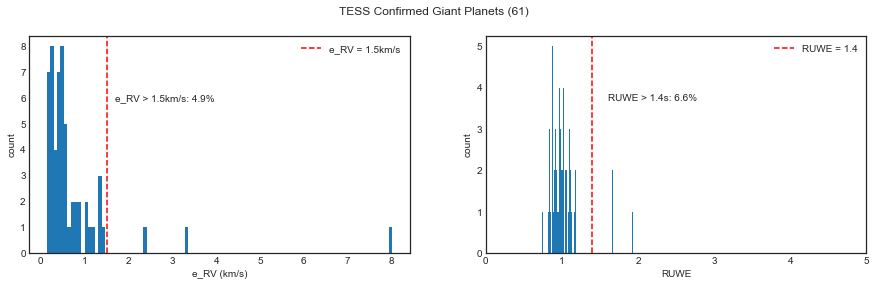

In [72]:
# Plot results

import matplotlib.pyplot as plt

plt.style.use("seaborn-white")

df_f = df_gaia

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle(f"{plot_title} ({len(df_f)})");

ax = axs[0]
ax.hist(df_f["e_RV"], bins=100);
ax.axvline(1.5, linestyle="--", c="red", label="e_RV = 1.5km/s");
ratio_large_e_rv = len(df_f[df_f["e_RV"] > 1.5]) / len(df_f)
ax.text(1.7, ax.get_ylim()[1] * 0.7, f"e_RV > 1.5km/s: {100* ratio_large_e_rv:.1f}%")
ax.legend();
ax.set_xlabel("e_RV (km/s)");
ax.set_ylabel("count");

ax = axs[1]
ax.hist(df_f["RUWE"], bins=100);
ax.axvline(1.4, linestyle="--", c="red", label="RUWE = 1.4");
ratio_large_ruwe = len(df_f[df_f["RUWE"] > 1.4]) / len(df_f)
ax.text(1.6, ax.get_ylim()[1] * 0.7, f"RUWE > 1.4s: {100* ratio_large_ruwe:.1f}%")
ax.legend();
ax.set_xlabel("RUWE");
ax.set_ylabel("count");
ax.set_xlim(0, 5);